In [1]:
%pip install kagglehub

  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.4-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (37 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached certifi-2026.1.4-py3-none-any.whl.metadata (2.5 kB)
Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (807 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.4-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (153 kB)
Using cached idna-3.11-py3-none-any.whl (71 kB)
Using cached urllib3-2.6.3-py3-none-any.whl (131 kB)
Using cached certifi-2026.1.4-py3-none-any.whl (152 kB)
   ━━━━━━━━━━━━━━━━━━━━

In [6]:
%pip install torch
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install pandas
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 9.6 MB/s  0:00:016m0:00:0100:01
Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (35.0 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import copy
import shutil
from collections import defaultdict
import random

/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
path = kagglehub.dataset_download("lsind18/gemstones-images")
#path = kagglehub.dataset_download("juniorbueno/rating-opencv-emotion-images")
print("Path to dataset files:", path)

Path to dataset files: /home/oogis/.cache/kagglehub/datasets/lsind18/gemstones-images/versions/6


In [29]:
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [30]:
target_dir = base_dir

In [34]:
def collect_all_images(dataset_path):
    """
    Собирает все изображения из папок train и test оригинального датасета
    Возвращает словарь: {класс: [список путей к изображениям]}
    """
    all_images = defaultdict(list)
    
    # Проходим по папкам train и test
    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"Папка {split_path} не найдена")
            continue
            
        # Проходим по классам в каждой папке
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
                
            # Собираем все изображения в этом классе
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    img_path = os.path.join(class_path, img_file)
                    all_images[class_name].append(img_path)
    
    return all_images

# Собираем все изображения
all_images = collect_all_images(path)


In [35]:
def split_and_save_dataset(all_images, target_base_dir, train_ratio=0.6, val_ratio=0.2, seed=42):
    random.seed(seed)
    
    for class_name, image_paths in sorted(all_images.items()):
        # Перемешиваем изображения
        random.shuffle(image_paths)
        
        # Вычисляем размеры выборок
        total = len(image_paths)
        n_train = int(total * train_ratio)
        n_val = int(total * val_ratio)
        
        # Разделяем на три части
        train_paths = image_paths[:n_train]
        val_paths = image_paths[n_train:n_train + n_val]
        test_paths = image_paths[n_train + n_val:]
        
        # Создаем папки для класса
        for split in ['train', 'val', 'test']:
            class_dir = os.path.join(target_base_dir, split, class_name)
            os.makedirs(class_dir, exist_ok=True)
        
        # Копируем файлы
        # Train
        for src_path in train_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'train', class_name, filename)
            shutil.copy2(src_path, dst_path)
        
        # Validation
        for src_path in val_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'val', class_name, filename)
            shutil.copy2(src_path, dst_path)
        
        # Test
        for src_path in test_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'test', class_name, filename)
            shutil.copy2(src_path, dst_path)
            
# Запускаем разделение
split_stats = split_and_save_dataset(all_images, target_dir, train_ratio=0.6, val_ratio=0.2)

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cpu


In [61]:
NUM_EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.01

In [62]:
data_dir = target_dir

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Более сильный кроп
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),  # Случайный поворот
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Вариации цвета
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Сдвиги
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [63]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}

In [64]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Классы: {class_names}")
print(f"Размеры датасета: Train: {dataset_sizes['train']}, Val: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

Классы: ['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andalusite', 'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Cats Eye', 'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 'Chrysoprase', 'Citrine', 'Coral', 'Danburite', 'Diamond', 'Diaspore', 'Dumortierite', 'Emerald', 'Fluorite', 'Garnet Red', 'Goshenite', 'Grossular', 'Hessonite', 'Hiddenite', 'Iolite', 'Jade', 'Jasper', 'Kunzite', 'Kyanite', 'Labradorite', 'Lapis Lazuli', 'Larimar', 'Malachite', 'Moonstone', 'Morganite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 'Opal', 'Pearl', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 'Quartz Rose', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Scapolite', 'Serpentine', 'Sodalite', 'Spe

In [76]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))
#model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
#model_ft.classifier[1] = nn.Linear(model_ft.classifier[1].in_features, len(class_names))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/oogis/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:16<00:00, 6.33MB/s]


In [79]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [80]:
for name, param in model_ft.named_parameters():
    if "fc.weight" not in name and "fc.bias" not in name:#if "classifier.1.weight" not in name and "classifier.1.bias" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [81]:
model_ft = model_ft.to(device)
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)

In [82]:
print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")


Всего параметров: 23,686,295
Обучаемых параметров: 178,263 (0.8%)


In [83]:
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE, momentum=0.9)
optimizer_ft = optim.AdamW(
    filter(lambda p: p.requires_grad, model_ft.parameters()), 
    lr=LEARNING_RATE, 
    weight_decay=0.01 
)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=NUM_EPOCHS)

In [84]:
from tqdm import tqdm
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Внешний прогресс-бар для эпох
    epoch_pbar = tqdm(range(num_epochs), desc='Epochs', position=0)
    
    for epoch in epoch_pbar:
        # Обновляем описание для эпохи
        epoch_pbar.set_description(f'Epoch {epoch}/{num_epochs-1}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                # Прогресс-бар для тренировки
                pbar = tqdm(dataloaders[phase], desc=f'Training', 
                           leave=False, position=1)
            else:
                model.eval()
                # Прогресс-бар для валидации
                pbar = tqdm(dataloaders[phase], desc=f'Validation', 
                           leave=False, position=1)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Обновляем прогресс-бар с текущими метриками
                if phase == 'train':
                    pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'acc': f'{torch.sum(preds == labels.data).item()/len(labels):.4f}'
                    })
                else:
                    pbar.set_postfix({
                        'val_acc': f'{torch.sum(preds == labels.data).item()/len(labels):.4f}'
                    })

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Обновляем описание основного прогресс-бара
            if phase == 'train':
                epoch_pbar.set_postfix({
                    'train_loss': f'{epoch_loss:.4f}',
                    'train_acc': f'{epoch_acc:.4f}'
                })
            else:
                epoch_pbar.set_postfix({
                    'train_loss': f'{history["train_loss"][-1]:.4f}' if history['train_loss'] else 0,
                    'train_acc': f'{history["train_acc"][-1]:.4f}' if history['train_acc'] else 0,
                    'val_loss': f'{epoch_loss:.4f}',
                    'val_acc': f'{epoch_acc:.4f}'
                })

            # Сохраняем лучшую модель
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Показываем сообщение о новом лучшем результате

    time_elapsed = time.time() - since
    print(f'\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f' Best val Acc: {best_acc:.4f}')

    # Загружаем лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                num_epochs=NUM_EPOCHS)

Epoch 8/14:  53%|█████▎    | 8/15 [25:18<20:42, 177.43s/it, train_loss=1.2175, train_acc=0.7102]                                 

In [ ]:
model_path = 'best_model_resNet50.pth'
torch.save(model_ft.state_dict(), model_path)
print(f"Модель сохранена как {model_path}")

Модель сохранена как best_model_resNet18.pth


In [ ]:
def evaluate_model_with_f1(model, dataloader, class_names, dataset_size):
    """
    Оценка модели с использованием F1-score и матрицы ошибок
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Оценка модели на тестовой выборке...")
    print("-" * 50)
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Преобразуем в numpy массивы
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # 1. Считаем accuracy (для сравнения)
    accuracy = np.mean(all_preds == all_labels)
    
    # 2. Считаем macro F1-score (среднее по классам)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    # 3. Считаем weighted F1-score (взвешенное по поддержке классов)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    
    # 4. Считаем per-class F1-score
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (weighted): {f1_weighted:.4f}")
    print()
    
    # 5. Детальный отчет по классам
    print("Детальный отчет по классам:")
    print("-" * 70)
    print(f"{'Класс':<25} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support':<10}")
    print("-" * 70)
    
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name:<25} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10.0f}")
    
    print("-" * 70)
    print(f"{'Среднее (macro)':<25} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} {report['macro avg']['f1-score']:<10.4f} {dataset_size:<10.0f}")
    
    return all_preds, all_labels, all_probs, {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'report': report
    }

# Запускаем оценку
preds, labels, probs, metrics = evaluate_model_with_f1(
    model_ft, dataloaders['test'], class_names, dataset_sizes['test']
)

Оценка модели на тестовой выборке...
--------------------------------------------------
Accuracy: 0.6006
F1-score (macro): 0.5966
F1-score (weighted): 0.6002

Детальный отчет по классам:
----------------------------------------------------------------------
Класс                     Precision  Recall     F1-score   Support   
----------------------------------------------------------------------
Alexandrite               0.3636     0.4444     0.4000     9         
Almandine                 1.0000     0.2857     0.4444     7         
Amazonite                 0.8571     0.7500     0.8000     8         
Amber                     0.5000     0.4286     0.4615     7         
Amethyst                  0.5000     0.3333     0.4000     9         
Ametrine                  0.7273     0.8889     0.8000     9         
Andalusite                0.2609     0.7500     0.3871     8         
Andradite                 0.2857     0.5714     0.3810     7         
Aquamarine                0.4286     0.33

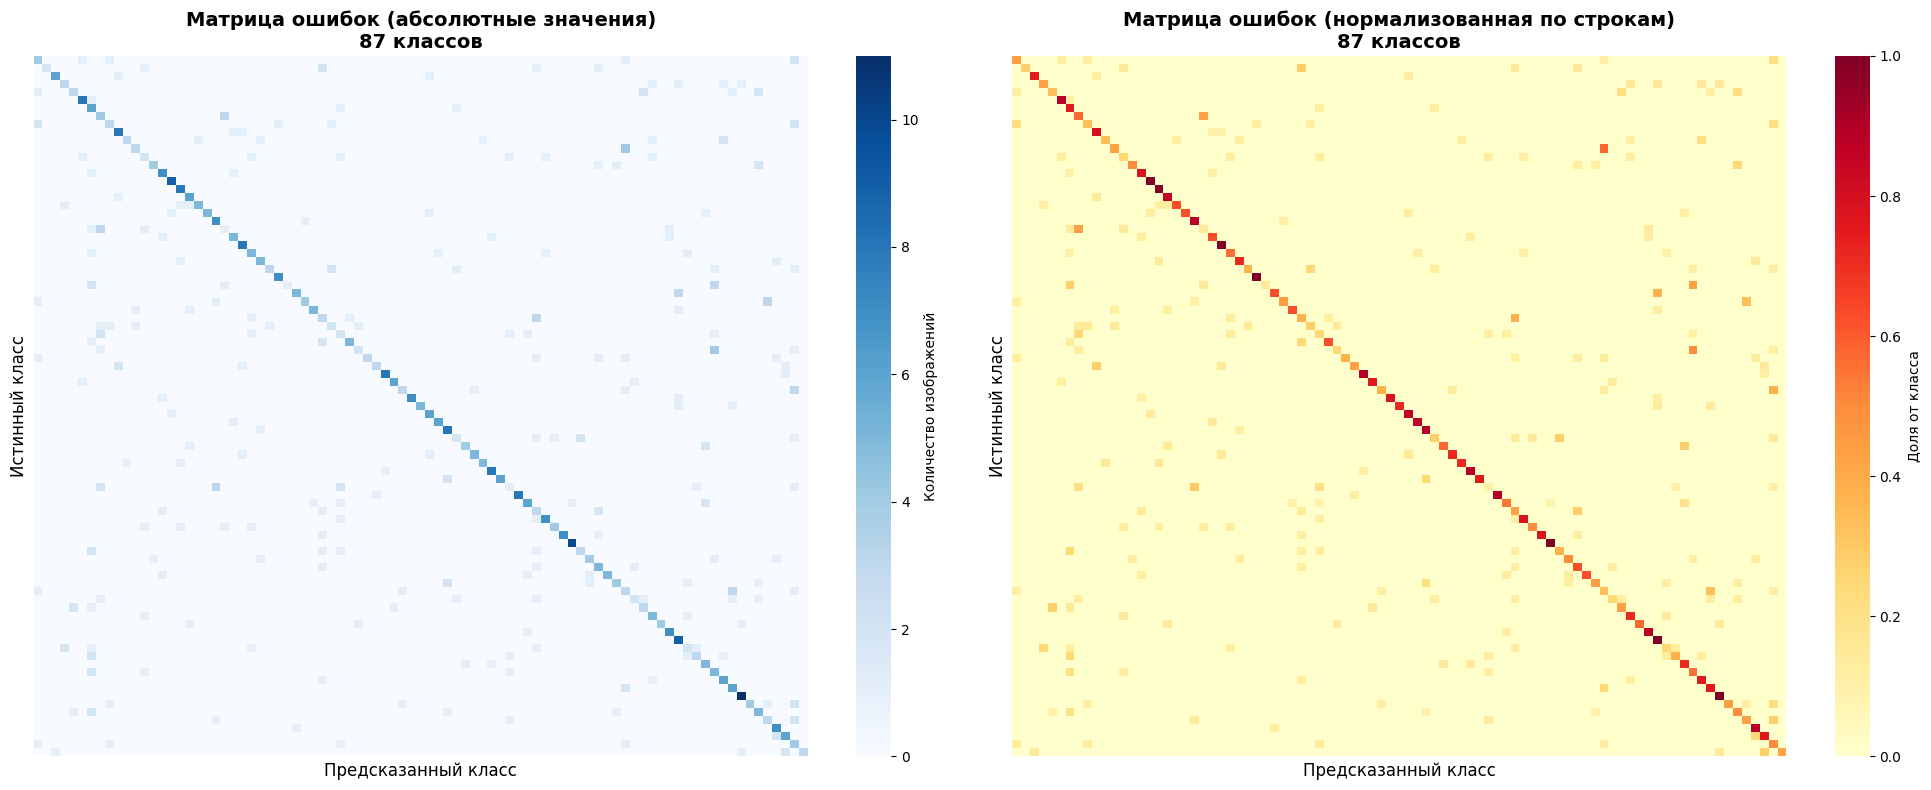


🔍 Анализ самых частых ошибок:
📊 Всего изображений: 706
✅ Правильно: 424 (60.06%)
❌ Ошибок: 282 (39.94%)
------------------------------------------------------------

📌 Топ-10 самых частых ошибок:
 1. Hiddenite                           → Spodumene                           :    4 (50.0%)
 2. Benitoite                           → Sapphire Blue                       :    4 (57.1%)
 3. Sapphire Blue                       → Tanzanite                           :    3 (33.3%)
 4. Peridot                             → Chrome Diopside                     :    3 (30.0%)
 5. Kyanite                             → Zircon                              :    3 (37.5%)
 6. Garnet Red                          → Pyrope                              :    3 (37.5%)
 7. Emerald                             → Tsavorite                           :    3 (33.3%)
 8. Dumortierite                        → Sodalite                            :    3 (37.5%)
 9. Diaspore                            → Spodumene        

In [ ]:
def plot_confusion_matrix(all_labels, all_preds, class_names):
    """
    Матрица ошибок: тепловая карта + текстовый анализ
    Для 87 классов - подписи классов убираем, оставляем только визуализацию
    """
    # Вычисляем матрицу ошибок
    cm = confusion_matrix(all_labels, all_preds)
    
    # Создаем фигуру
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Абсолютные значения (тепловая карта без подписей)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=False, yticklabels=False,  # Убираем подписи
                ax=axes[0], cbar_kws={'label': 'Количество изображений'})
    axes[0].set_title('Матрица ошибок (абсолютные значения)\n87 классов', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Истинный класс', fontsize=12)
    axes[0].set_xlabel('Предсказанный класс', fontsize=12)
    
    # 2. Нормализованные значения (тепловая карта без подписей)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='YlOrRd', 
                xticklabels=False, yticklabels=False,  # Убираем подписи
                ax=axes[1], cbar_kws={'label': 'Доля от класса'}, 
                vmin=0, vmax=1)
    axes[1].set_title('Матрица ошибок (нормализованная по строкам)\n87 классов', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Истинный класс', fontsize=12)
    axes[1].set_xlabel('Предсказанный класс', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ самых частых ошибок (текстовый вывод)
    print("\n🔍 Анализ самых частых ошибок:")
    print("=" * 60)
    
    # Общая статистика
    total_samples = len(all_labels)
    correct = np.trace(cm)
    accuracy = correct / total_samples
    
    print(f"📊 Всего изображений: {total_samples}")
    print(f"✅ Правильно: {correct} ({accuracy:.2%})")
    print(f"❌ Ошибок: {total_samples - correct} ({1-accuracy:.2%})")
    print("-" * 60)
    
    # Находим топ ошибок (убираем диагональ)
    cm_errors = cm.copy()
    np.fill_diagonal(cm_errors, 0)
    
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm_errors[i, j] > 0:
                errors.append((cm_errors[i, j], i, j))
    
    errors.sort(reverse=True)
    
    # Топ-10 ошибок с названиями классов
    print("\n📌 Топ-10 самых частых ошибок:")
    for idx, (count, true_idx, pred_idx) in enumerate(errors[:10], 1):
        error_percent = count / cm[true_idx].sum() * 100
        print(f"{idx:2d}. {class_names[true_idx]:35} → {class_names[pred_idx]:35} : {count:4d} ({error_percent:.1f}%)")
    
    return cm, cm_normalized

# Используем функцию
cm, cm_norm = plot_confusion_matrix(labels, preds, class_names)